This notebook aims to:

- Check the aurora quality: VIIRS image manually labelled by me
- Compare the VIIRS labels with archieved Kp index values
- Try to see when is suitable for chasing aurora in March 2025

In [1]:
import spaceweather as sw
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import rcParams
font_size = 15
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

## Read VIIRS data (checked manually)

In [3]:
df_Mar_viirs = pd.read_csv('../data/Aurora_Worldview_Mar.csv')
df_Feb_viirs = pd.read_csv('../data/Aurora_Worldview_Feb.csv')
df_Jan_viirs = pd.read_csv('../data/Aurora_Worldview_Jan.csv')

## Read Spaceweather data

In [4]:
sw.sw_daily().columns

Index(['year', 'month', 'day', 'bsrn', 'rotd', 'Kp0', 'Kp3', 'Kp6', 'Kp9',
       'Kp12', 'Kp15', 'Kp18', 'Kp21', 'Kpsum', 'Ap0', 'Ap3', 'Ap6', 'Ap9',
       'Ap12', 'Ap15', 'Ap18', 'Ap21', 'Apavg', 'Cp', 'C9', 'isn', 'f107_adj',
       'Q', 'f107_81ctr_adj', 'f107_81lst_adj', 'f107_obs', 'f107_81ctr_obs',
       'f107_81lst_obs'],
      dtype='object')

In [5]:
sw.gfz_daily().columns

Index(['year', 'month', 'day', 'days', 'days_m', 'bsrn', 'rotd', 'Kp0', 'Kp3',
       'Kp6', 'Kp9', 'Kp12', 'Kp15', 'Kp18', 'Kp21', 'Kpsum', 'Ap0', 'Ap3',
       'Ap6', 'Ap9', 'Ap12', 'Ap15', 'Ap18', 'Ap21', 'Apavg', 'isn',
       'f107_obs', 'f107_adj', 'D'],
      dtype='object')

In [6]:
# 3h Ap and Kp values
# df_3h = sw.ap_kp_3h()
df_3h = sw.ap_kp_3h(update=True)

# select night time in Norway, Europe
df_subset = df_3h.between_time('16:00', '05:00')

# select Jan to Mar
df_Jan_Mar = df_subset[(df_subset.index.month >= 1) & (df_subset.index.month <= 3)]
df_Jan_Mar_2017_2023 = df_Jan_Mar.loc['2017-1-1':'2023-4-1']

df_Jan_Mar_2017_2023_daily_mean = df_Jan_Mar_2017_2023.groupby(df_Jan_Mar_2017_2023.index.date).mean()

def normalize_column(df, column):
    if column == 'Kp':
        max_value = 9
    else:
        max_value = df[column].max()
    return (df[column]-df[column].min())/(df[column].max()-df[column].min())

df_Jan_Mar_2017_2023_daily_mean['Ap_norm'] = normalize_column(df_Jan_Mar_2017_2023_daily_mean, 'Ap')
df_Jan_Mar_2017_2023_daily_mean['Kp_norm'] = normalize_column(df_Jan_Mar_2017_2023_daily_mean, 'Kp')

## Comparisons

In [7]:
def create_quality_heatmap_viirs(ax, df, month_label):
    """
    Create a heatmap from datetime and quality data.
    
    Parameters:
    df: pandas DataFrame with 'datetime' and 'quality' columns
    """
    # Convert datetime to year and day
    df['year'] = pd.to_datetime(df['datetime']).dt.year
    df['day'] = pd.to_datetime(df['datetime']).dt.day
    
    # Pivot the data to create a matrix suitable for heatmap
    # rows will be days, columns will be years, values will be quality
    pivot_data = df.pivot(index='day', columns='year', values='quality')
    
    # Create the heatmap
    sns.heatmap(pivot_data, 
                ax=ax,
                cmap='Blues',  # Use blue color palette
                annot=False,
                # annot=True,    # Show values in cells
                # fmt='.2f',     # Format values to 2 decimal places
                cbar_kws={'label': 'Quality'},
                vmin=0,        # Set minimum value for color scale
                vmax=1)        # Set maximum value for color scale
    
    # Customize the plot
    # plt.title(f'Aurora Quality ({month_label})')
    ax.set_xlabel('Year')
    ax.set_ylabel(f'Day of Month {month_label}')

In [8]:
def create_quality_heatmap_spaceweather(ax, df, month_label, column='Kp'):
    """
    Create a heatmap from datetime and quality data.
    
    Parameters:
    df: pandas DataFrame with 'datetime' and 'quality' columns
    """
    df = df[pd.to_datetime(df.index).month == month_label]
    # Convert datetime to year and day
    df['year'] = pd.to_datetime(df.index).year
    df['day'] = pd.to_datetime(df.index).day

    # Pivot the data to create a matrix suitable for heatmap
    # rows will be days, columns will be years, values will be quality
    pivot_data = df.pivot(index='day', columns='year', values=column)
    
    # Create the heatmap
    sns.heatmap(pivot_data,
                ax=ax,
                cmap='Blues',  # Use blue color palette
                annot=False,
                # annot=True,    # Show values in cells
                # fmt='.2f',     # Format values to 2 decimal places
                cbar_kws={'label': column},
                vmin=0,        # Set minimum value for color scale
                vmax=1,        # Set maximum value for color scale
    )

    # Customize the plot
    # ax.set_title(f'Aurora Quality (Month {month_label})')
    ax.set_xlabel('Year')
    ax.set_ylabel(f'Day of Month {month_label}')

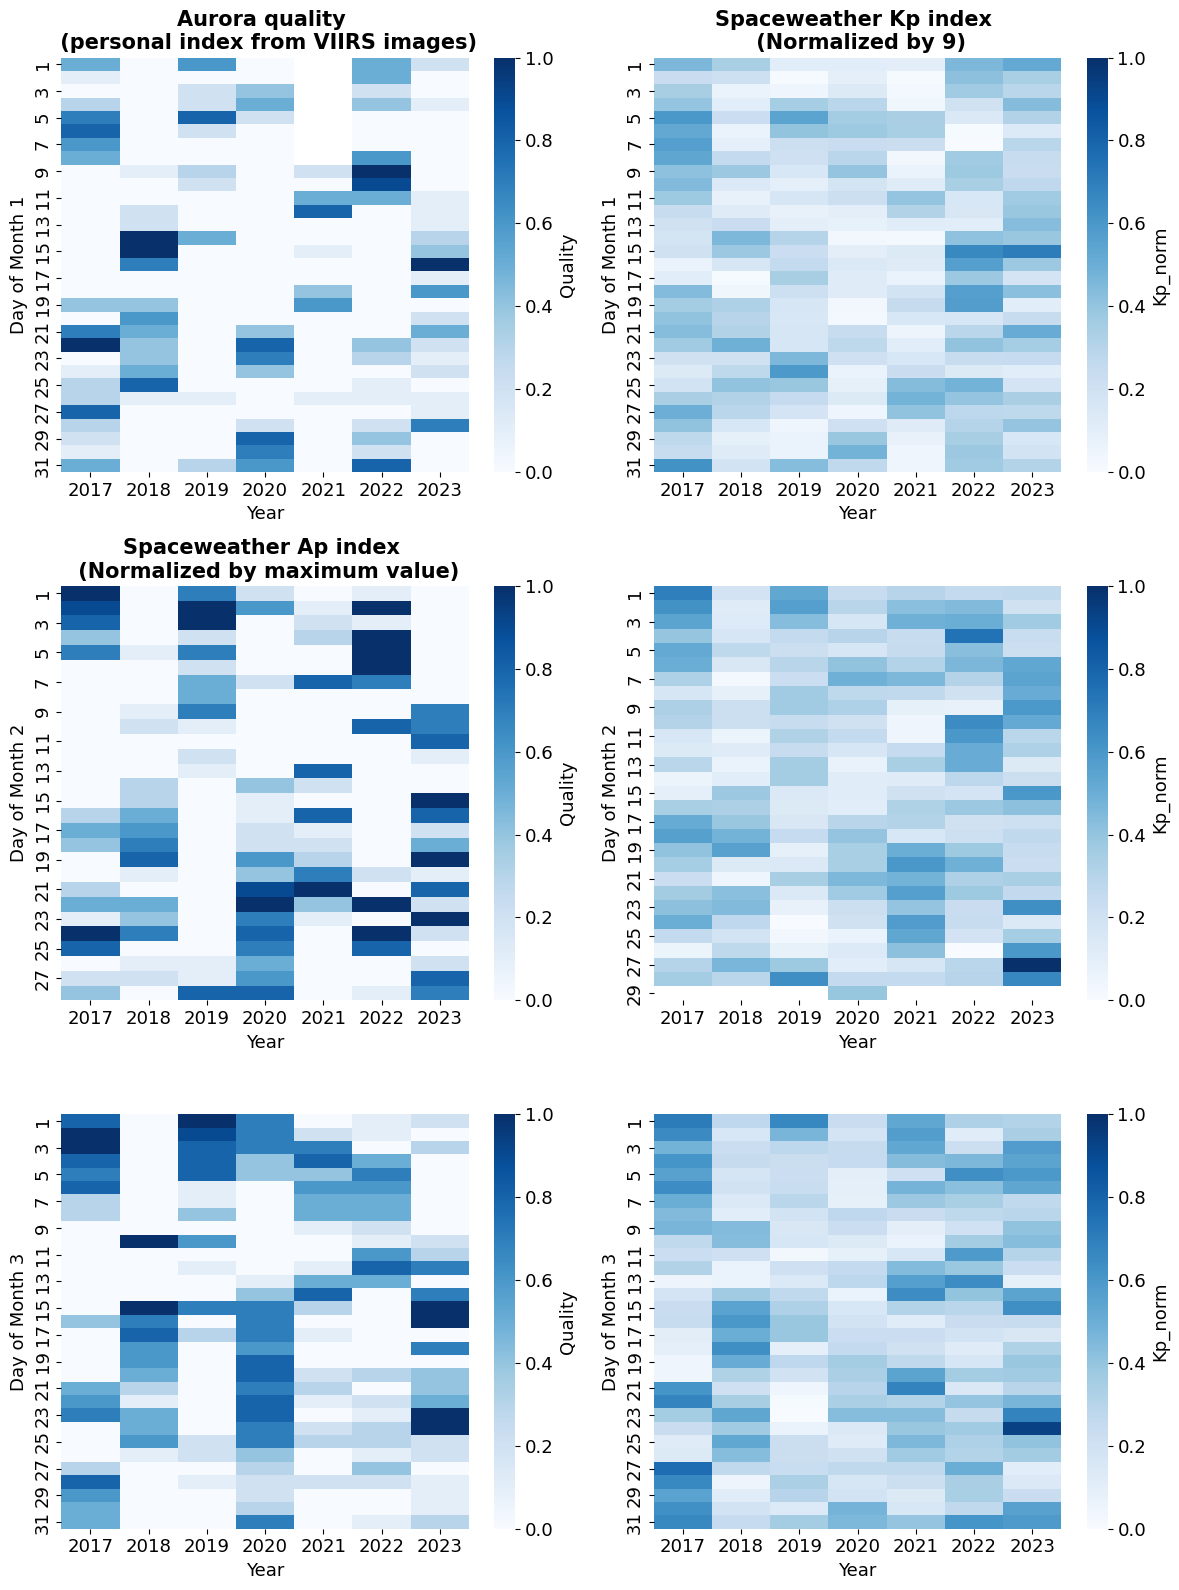

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 16))

axs = axs.flatten()

# Jan
create_quality_heatmap_viirs(axs[0], df_Jan_viirs, month_label=1)
create_quality_heatmap_spaceweather(axs[1], df_Jan_Mar_2017_2023_daily_mean, month_label=1, column='Kp_norm')

# Feb
create_quality_heatmap_viirs(axs[2], df_Feb_viirs, month_label=2)
create_quality_heatmap_spaceweather(axs[3], df_Jan_Mar_2017_2023_daily_mean, month_label=2, column='Kp_norm')

# March
create_quality_heatmap_viirs(axs[4], df_Mar_viirs, month_label=3)
create_quality_heatmap_spaceweather(axs[5], df_Jan_Mar_2017_2023_daily_mean, month_label=3, column='Kp_norm')

axs[0].set_title('Aurora quality \n (personal index from VIIRS images)')
axs[1].set_title('Spaceweather Kp index \n (Normalized by 9)')
axs[2].set_title('Spaceweather Ap index \n (Normalized by maximum value)')

fig.tight_layout()

Nice! The manual checklist agrees with the Kp values. Now we can just play with the spaceweather data!

**Important tip:**

It seems the high-value patterns are same from Jan to March for all these years ;)

So, maybe we can just use the Kp values in Jan 2025 to predict aurora activities in March ....

## Time series

### Solar cycle

In [10]:
df_daily = sw.sw_daily()

Text(0, 0.5, 'Sunspot Number')

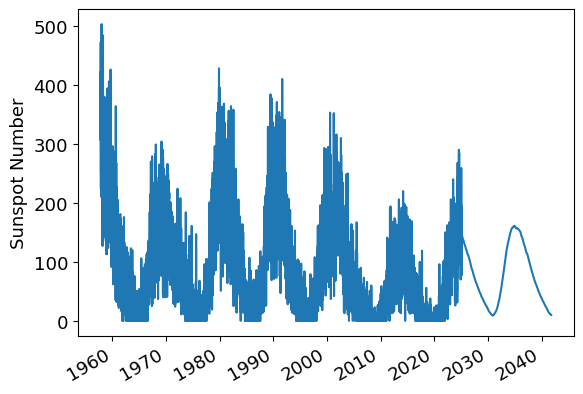

In [11]:
df_daily['isn'].plot()
plt.ylabel('Sunspot Number')

### Kp index

I'm planning to visit Norway in March, so I just pick Jan-Apr to see the trend.

In [12]:
df_2010_2025 = df_subset[(df_subset.index.month >= 1) & (df_subset.index.month <= 4)].loc['2010-1-1':'2025-4-30']
df_2010_2025_daily_mean = df_2010_2025.groupby(df_2010_2025.index.date).mean()
df_2010_2025_daily_mean['Kp_norm'] = normalize_column(df_2010_2025_daily_mean, 'Kp')

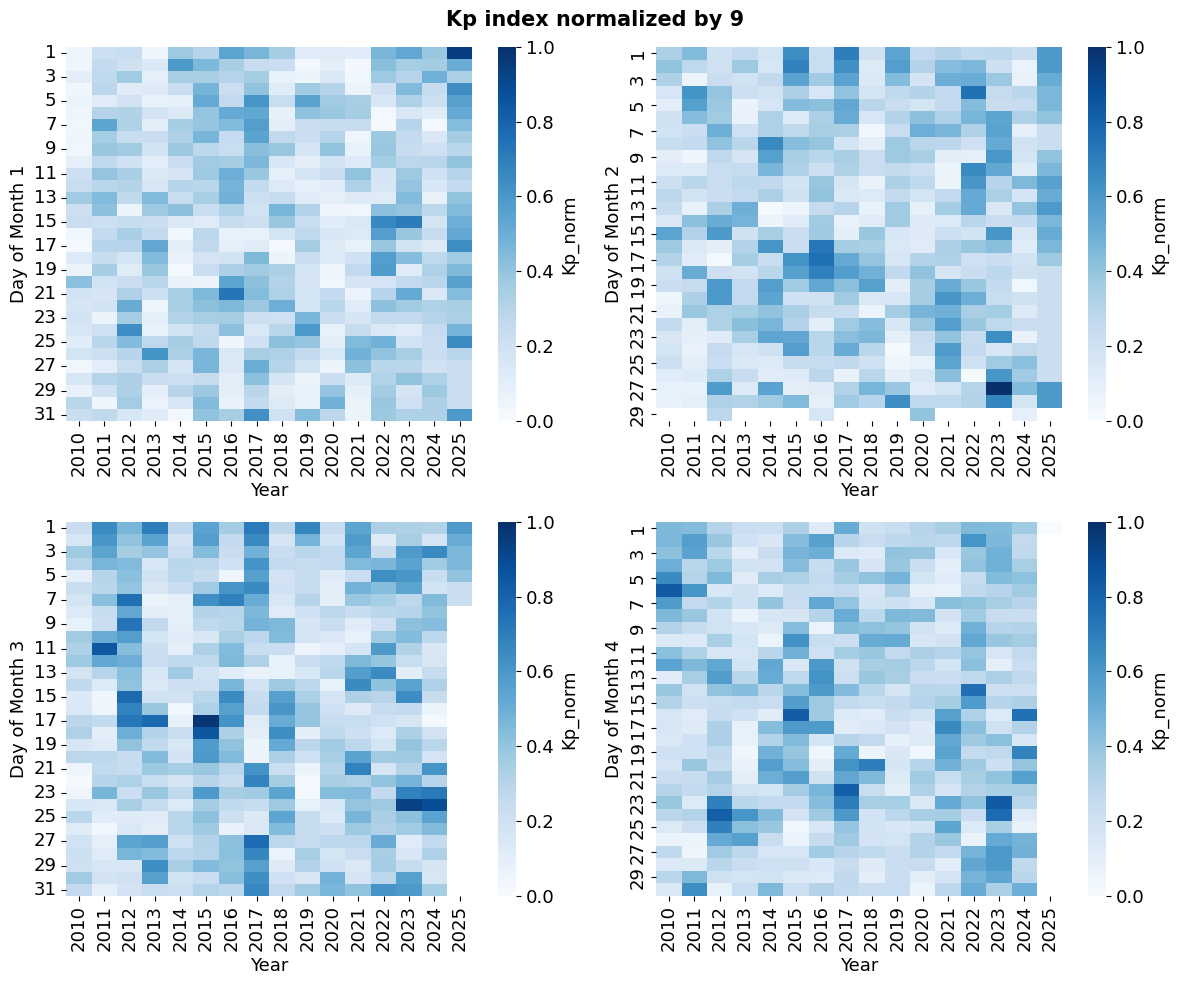

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

axs = axs.flatten()

# Feb
create_quality_heatmap_spaceweather(axs[0], df_2010_2025_daily_mean, month_label=1, column='Kp_norm')
create_quality_heatmap_spaceweather(axs[1], df_2010_2025_daily_mean, month_label=2, column='Kp_norm')
create_quality_heatmap_spaceweather(axs[2], df_2010_2025_daily_mean, month_label=3, column='Kp_norm')
create_quality_heatmap_spaceweather(axs[3], df_2010_2025_daily_mean, month_label=4, column='Kp_norm')

plt.suptitle('Kp index normalized by 9')
fig.tight_layout()

Wow, there're even forecast data after today (2025-01-24) ....

I feel 13-25 March, 2025 would be a nice time window for aurora. Finger crossed!